# **Forecasting Ethiopia wheat production By using SARIMAX model**

In [1]:
!pip install pandas numpy matplotlib statsmodels seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# **Load Data**

The data were loaded fro FAOSTAT data base. To do this, the data were sorted on the basis of item-wheat, yearand elements like production quantity, Area harvested and yield.

In [3]:
# Load dataset
df = pd.read_csv("Ethiopia Wheat  data from FAOSTAT.csv",index_col='Year', parse_dates=True)
# Inspect data
print(df.head())
print(df.describe())
print(df.info())

                                  Domain      Area         Element   Item  \
Year                                                                        
1993-01-01  Crops and livestock products  Ethiopia  Area harvested  Wheat   
1993-01-01  Crops and livestock products  Ethiopia           Yield  Wheat   
1993-01-01  Crops and livestock products  Ethiopia      Production  Wheat   
1994-01-01  Crops and livestock products  Ethiopia  Area harvested  Wheat   
1994-01-01  Crops and livestock products  Ethiopia           Yield  Wheat   

             Unit     Value  
Year                         
1993-01-01     ha  578230.0  
1993-01-01  kg/ha    1548.7  
1993-01-01      t  895520.0  
1994-01-01     ha  746810.0  
1994-01-01  kg/ha    1074.9  
              Value
count  8.700000e+01
mean   1.436889e+06
std    1.588707e+06
min    1.074900e+03
25%    2.752000e+03
50%    1.142710e+06
75%    1.768656e+06
max    5.807800e+06
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 1993-

For convinence, only wheat is filtered and column adjusted as follows:

In [4]:

# Filter only wheat
df_wheat = df[df['Item'] == 'Wheat']

In [7]:
df_wheat.head()

,Domain,Area,Element,Item,Unit,Value
Year,,,,,,
1993-01-01,Crops and livestock products,Ethiopia,Area harvested,Wheat,ha,578230.0
1993-01-01,Crops and livestock products,Ethiopia,Yield,Wheat,kg/ha,1548.7
1993-01-01,Crops and livestock products,Ethiopia,Production,Wheat,t,895520.0
1994-01-01,Crops and livestock products,Ethiopia,Area harvested,Wheat,ha,746810.0
1994-01-01,Crops and livestock products,Ethiopia,Yield,Wheat,kg/ha,1074.9


To access columns like such as Production, Area harvested and yield, pivot table was created and index was reset.

In [5]:
# Pivot so that Elements become columns
df_wheat_pivot = df_wheat.pivot_table(
    index='Year',          # keep Year as index
    columns='Element',     # values in Element become columns
    values='Value'         # take the Value column
)
df_wheat_pivot = df_wheat_pivot.reset_index()

print(df_wheat_pivot.head())

Element       Year  Area harvested  Production   Yield
0       1993-01-01        578230.0    895520.0  1548.7
1       1994-01-01        746810.0    802747.0  1074.9
2       1995-01-01        826840.0   1083680.0  1310.6
3       1996-01-01        959450.0   1162310.0  1211.4
4       1997-01-01        846000.0   1092820.0  1291.7


production data type were recorded as an oject, to fix these all data types were changed to float.

In [10]:
df_wheat_pivot[['Area harvested', 'Yield', 'Production']] = df_wheat_pivot[['Area harvested', 'Yield', 'Production']].astype(float)

# **Explatory Data Analysis**

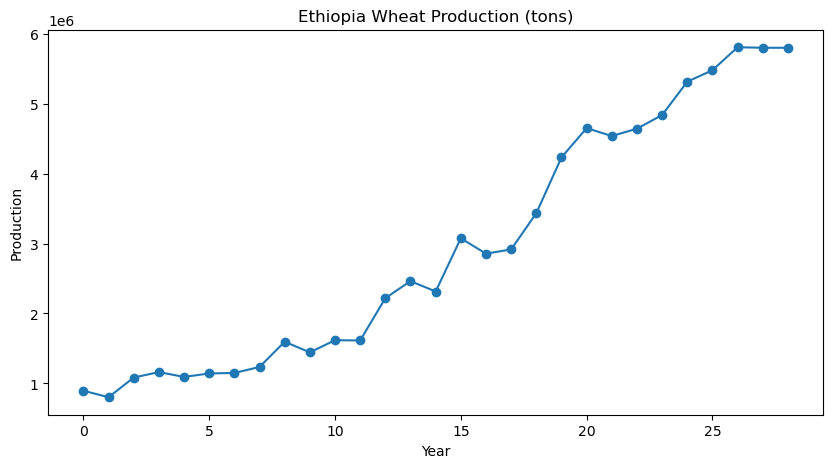

In [6]:
# Plot Production over time
plt.figure(figsize=(10,5))
plt.plot(df_wheat_pivot['Production'], marker='o')
plt.title("Ethiopia Wheat Production (tons)")
plt.ylabel("Production")
plt.xlabel("Year")
plt.show()


In [ ]:
df_wheat_pivot.info()

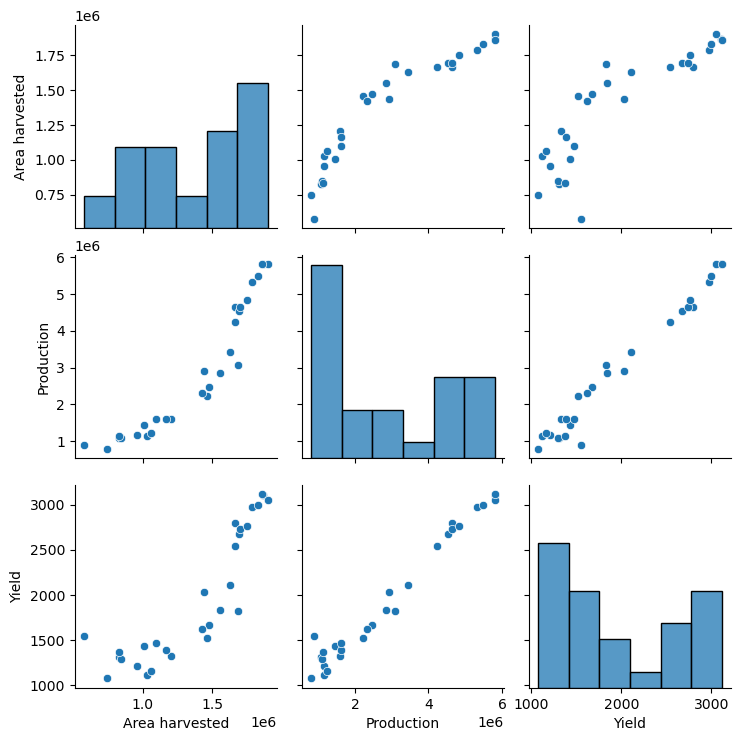

In [14]:

# Pairplot to see relationships
sns.pairplot(df_wheat_pivot)
plt.show()


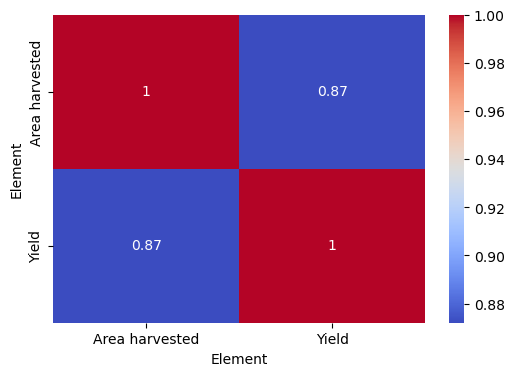

In [7]:

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    df_wheat_pivot.drop(columns=["Production","Year"]).corr(),
    annot=True,
    cmap='coolwarm'
)
plt.show()

Wow! it seems there is strong correlation among area Area harvested and yield, which indicates the existence of multicllineraity problem. Thus, we need to drop one from them, for Our ethiopian case, Area harvested selected as predictor variable.

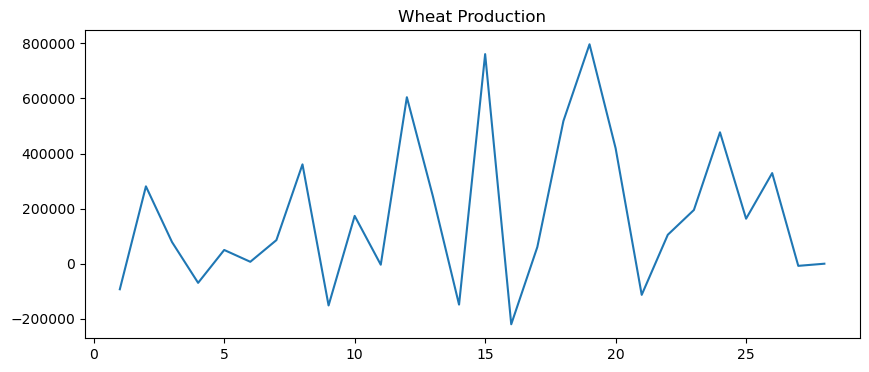

In [44]:
#checking seasonality of wheat production
df_wheat_pivot["Production_diff"].plot(figsize=(10,4), title="Wheat Production")
plt.show()

**Check Stationarity (ADF Test)**

In [30]:
result = adfuller(df_wheat_pivot["Production"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("❌ Non-stationary → Differencing needed (d=1).")
else:
    print("✅ Stationary → No differencing needed (d=0).")


ADF Statistic: 0.4344232348174857
p-value: 0.9827375955091544
❌ Non-stationary → Differencing needed (d=1).


*Let us take one difference for production, our target variable.*

In [12]:
df_wheat_pivot["Production_diff"] = df_wheat_pivot["Production"].diff().dropna()

**Plot ACF & PACF (on Production series)**

Text(0.5, 1.0, 'ACF (After differencing)')

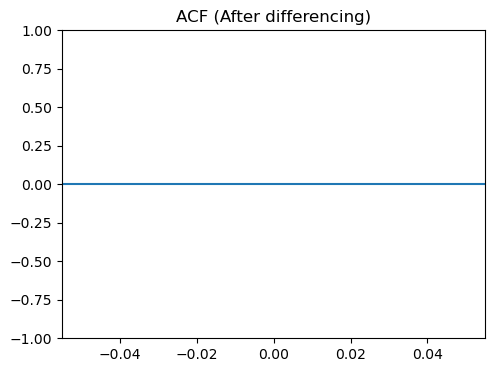

In [41]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df_wheat_pivot["Production_diff"], lags=20, ax=plt.gca())
plt.title("ACF (After differencing)")

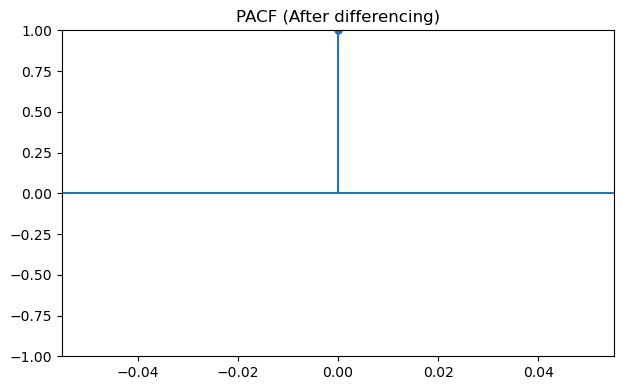

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plot_pacf(df_wheat_pivot["Production_diff"], lags=14, ax=plt.gca(), method='ywm')
plt.title("PACF (After differencing)")

plt.tight_layout()
plt.show()

Flat ACF → no significant moving average (MA) structure → q ≈ 0.

Flat PACF → no significant autoregressive (AR) structure → p ≈ 0.
In simple terms: your wheat production series is mainly driven by the predictor (Area harvested) and doesn’t have strong AR/MA structure.


# Prepare Target and Predictors

In [8]:
#Train/Test Split
# Use first 80% for training, last 20% for testing
train_size = int(len(df_wheat_pivot) * 0.8)
train, test = df_wheat_pivot.iloc[:train_size], df_wheat_pivot.iloc[train_size:]

y_train = train["Production"]
y_test = test["Production"]

X_train = train[["Area harvested"]]
X_test = test[["Area harvested"]]


**Build Model**

In [9]:
# Build model (order=(p,d,q) can be tuned)
model = SARIMAX(y_train, exog=X_train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   23
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -303.299
Date:                Thu, 25 Sep 2025   AIC                            614.598
Time:                        15:53:45   BIC                            618.962
Sample:                             0   HQIC                           615.626
                                 - 23                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Area harvested     1.4064      0.517      2.720      0.007       0.393       2.420
ar.L1              0.9334      0.810      1.152      0.249      -0.655       2.521
ma.L1             -0.7760      1.183

**Forecast and Evaluate**

In [10]:
# Forecast and evaluate 
# Number of periods to predict
n_test = len(y_test)

# Predict using X_test as exogenous
y_pred = model_fit.get_forecast(steps=n_test, exog=X_test).predicted_mean

# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 299454.93528896454


Great! That means the model is working, and the RMSE ≈ 29,9454.93528896454 gives us a sense of the average error in wheat production units (probably tons).

*Compare RMSE to the mean production*

In [11]:
mean_production = y_test.mean()
print("Mean Production:", mean_production)
print("RMSE as % of mean:", (rmse/mean_production)*100, "%")


Mean Production: 5506642.178333334
RMSE as % of mean: 5.438067802320851 %


*Average deviation is only ~5.4% of actual production — quite good for agricultural forecasts, which are naturally noisy.*

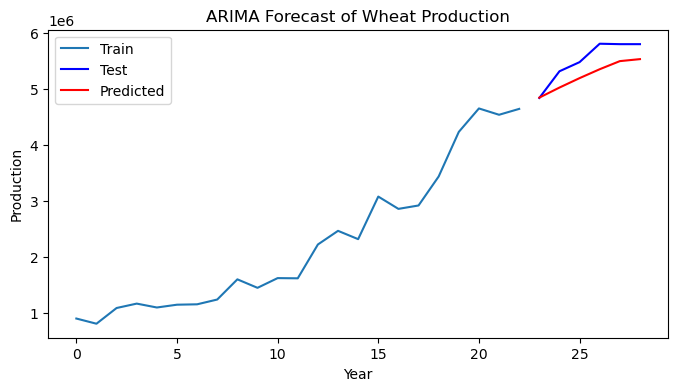

In [12]:
 #Plot actual vs predicted
plt.figure(figsize=(8,4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.title("ARIMA Forecast of Wheat Production")
plt.xlabel("Year")
plt.ylabel("Production")
plt.legend()
plt.show()

**Forecast future production for the next three years**

In [13]:

#Generate future Area harvested
# ------------------------
from sklearn.linear_model import LinearRegression
# Historical Area harvested
area = df_wheat_pivot["Area harvested"].values  # or "Area harvested" column

# Use index (years) as integers
years = df_wheat_pivot.index.values.reshape(-1,1)  

# Fit linear regression
model_area = LinearRegression()
model_area.fit(years, area)

# Predict next 3 years
future_years = np.array([2024, 2025, 2026]).reshape(-1,1)
predicted_area = model_area.predict(future_years)

# Prepare DataFrame for ARIMAX exogenous variable
future_area = pd.DataFrame({"Area harvested": predicted_area},
                           index=[2024, 2025, 2026])
print(future_area)


      Area harvested
2024    9.220585e+07
2025    9.225104e+07
2026    9.229623e+07


In [14]:
#Forecast future production
future_forecast = model_fit.get_forecast(steps=3, exog=future_area)
forecast_values = future_forecast.predicted_mean
print("Future Wheat Production Forecasts:\n", forecast_values)

Future Wheat Production Forecasts:
 23    1.320632e+08
24    1.322479e+08
25    1.324246e+08
Name: predicted_mean, dtype: float64


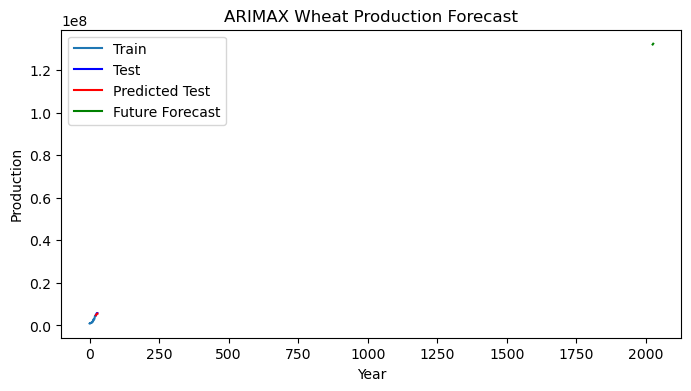

In [15]:
 #Plot results
# ------------------------
plt.figure(figsize=(8,4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Test", color="red")
plt.plot(future_area.index, forecast_values, label="Future Forecast", color="green")
plt.title("ARIMAX Wheat Production Forecast")
plt.xlabel("Year")
plt.ylabel("Production")
plt.legend()
plt.show()